## Train an Supervised XGBoost model using the data stored in feature store

In [119]:
import boto3
import sagemaker
from sagemaker.session import Session


region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

In [120]:
from sagemaker.feature_store.feature_group import FeatureGroup

fd_feature_group_name = 'transactionfeaturegroup001'

fd_feature_group = FeatureGroup(name=fd_feature_group_name, sagemaker_session=feature_store_session)

## Build Training Dataset

SageMaker FeatureStore automatically builds the Glue Data Catalog for FeatureGroups (you can optionally turn it on/off while creating the FeatureGroup). In this example, we want to create one training dataset with FeatureValues from both identity and transaction FeatureGroups. This is done by utilizing the auto-built Catalog. We run an Athena query that joins the data stored in the offline store in S3 from the 2 FeatureGroups. 

In [121]:
# You can modify the following to use a bucket of your choosing
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-demo'

print(default_s3_bucket_name)

sagemaker-us-east-1-365792799466


In [122]:
transaction_query = fd_feature_group.athena_query()

transaction_table = transaction_query.table_name

print(transaction_table)

query_string = 'SELECT * FROM "'+transaction_table+'"'
print('Running ' + query_string)

# run Athena query. The output is loaded to a Pandas dataframe.
#dataset = pd.DataFrame()
transaction_query.run(query_string=query_string, output_location='s3://'+default_s3_bucket_name+'/'+prefix+'/query_results/')
transaction_query.wait()
dataset = transaction_query.as_dataframe()

dataset

transactionfeaturegroup001-1629730459
Running SELECT * FROM "transactionfeaturegroup001-1629730459"


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v26,v27,v28,amount,class,event_time,record_id,write_time,api_invocation_time,is_deleted
0,66491.0,1.038279,-0.130291,1.033925,1.655057,-0.744910,0.105462,-0.344991,0.150649,0.861917,...,-0.281158,0.067173,0.030920,38.00,0.0,1.629730e+09,98040,2021-08-23 15:12:23.044,2021-08-23 15:07:23.000,False
1,97714.0,-0.388542,1.101771,0.822360,3.513811,2.657428,5.279897,-0.563090,1.273458,-0.498999,...,0.076305,0.423914,0.229938,38.44,0.0,1.629730e+09,152982,2021-08-23 15:12:23.044,2021-08-23 15:07:23.000,False
2,66500.0,-4.288288,3.183033,0.182823,-2.192241,-0.895712,-0.616880,0.288131,0.320984,2.884039,...,0.636795,0.306453,-0.042522,3.79,0.0,1.629730e+09,98061,2021-08-23 15:12:23.044,2021-08-23 15:07:23.000,False
3,41569.0,1.188135,-0.114837,0.627819,0.867755,-0.799783,-0.678143,-0.197147,-0.011396,0.766437,...,0.183728,-0.028844,0.016836,23.95,0.0,1.629730e+09,43591,2021-08-23 15:12:23.044,2021-08-23 15:07:23.000,False
4,41572.0,-2.939069,1.134611,1.489090,1.321609,-2.038069,-0.312985,-0.687178,1.097710,0.566128,...,-0.040770,0.546236,0.431051,100.00,0.0,1.629730e+09,43597,2021-08-23 15:12:23.044,2021-08-23 15:07:23.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164529,71458.0,1.332849,0.389198,-2.165597,-0.306873,2.641351,2.808084,-0.171627,0.683352,-0.297962,...,0.384013,-0.028465,0.036123,0.76,0.0,1.629730e+09,109615,2021-08-23 15:12:23.044,2021-08-23 15:09:54.000,False
164530,116765.0,2.015354,-1.495212,-1.866656,-1.897132,1.149671,3.702552,-1.644792,0.958487,-0.043716,...,-0.052810,0.023031,-0.039031,80.00,0.0,1.629730e+09,164501,2021-08-23 15:12:23.044,2021-08-23 15:09:55.000,False
164531,71481.0,-0.845700,1.112358,1.418798,1.293002,-0.120562,0.229485,0.110841,0.659793,-0.865973,...,-0.218297,0.021887,0.026942,4.50,0.0,1.629730e+09,109663,2021-08-23 15:12:23.044,2021-08-23 15:09:55.000,False
164532,71481.0,1.432014,-0.331789,-0.071307,-0.572398,-0.875061,-1.618266,-0.087151,-0.379435,-1.034945,...,-0.101541,-0.033708,0.002595,10.00,0.0,1.629730e+09,109665,2021-08-23 15:12:23.044,2021-08-23 15:09:55.000,False


In [123]:
dataset.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class', 'event_time', 'record_id', 'write_time', 'api_invocation_time',
       'is_deleted'],
      dtype='object')

In [124]:
# Select useful columns for training with target column as the first.
dataset = dataset[['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class']]


In [125]:
dataset = dataset.dropna()
dataset.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,66491.0,1.038279,-0.130291,1.033925,1.655057,-0.744910,0.105462,-0.344991,0.150649,0.861917,...,-0.047036,0.163616,-0.055206,0.434549,0.555950,-0.281158,0.067173,0.030920,38.00,0.0
1,97714.0,-0.388542,1.101771,0.822360,3.513811,2.657428,5.279897,-0.563090,1.273458,-0.498999,...,-0.293353,-0.643627,0.195229,0.578783,-0.677896,0.076305,0.423914,0.229938,38.44,0.0
2,66500.0,-4.288288,3.183033,0.182823,-2.192241,-0.895712,-0.616880,0.288131,0.320984,2.884039,...,-0.474655,-0.254928,0.141980,0.157453,0.058767,0.636795,0.306453,-0.042522,3.79,0.0
3,41569.0,1.188135,-0.114837,0.627819,0.867755,-0.799783,-0.678143,-0.197147,-0.011396,0.766437,...,-0.306293,-0.830371,0.080980,0.372789,0.277700,0.183728,-0.028844,0.016836,23.95,0.0
4,41572.0,-2.939069,1.134611,1.489090,1.321609,-2.038069,-0.312985,-0.687178,1.097710,0.566128,...,0.167211,0.693655,-0.303515,0.713439,0.363228,-0.040770,0.546236,0.431051,100.00,0.0


The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulant with only $492$ ($.173\%$) of the data corresponding to fraudulant examples.

In [126]:
nonfrauds, frauds = dataset.groupby('class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  358
Number of non-frauds:  164175
Percentage of fradulent data: 0.21758552995447722


This dataset has 28 columns, $V_i$ for $i=1..28$ of anonymized features along with columns for time, amount, and class. We already know that the columns $V_i$ have been normalized to have $0$ mean and unit standard deviation as the result of a PCA. You can read more about PCA here:. 

Tip: For our dataset this amount of preprocessing will give us reasonable accuracy, but it's important to note that there are more preprocessing steps one can use to improve accuracy . For unbalanced data sets like ours where the positive (fraudulent) examples occur much less frequently than the negative (legitimate) examples, we may try “over-sampling” the minority dataset by generating synthetic data (read about SMOTE in Data Mining for Imbalanced Datasets: An Overview (https://link.springer.com/chapter/10.1007%2F0-387-25465-X_40) or undersampling the majority class by using ensemble methods (see http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.6858&rep=rep1&type=pdfor).

In [127]:
feature_columns = dataset.columns[:-1]
label_column = dataset.columns[-1]

features = dataset[feature_columns].values.astype('float32')
labels = (dataset[label_column].values).astype('float32')

In [129]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42)

Let's do some analysis and discuss different ways we can preprocess our data. Let's discuss the way in which this data was preprocessed.

## Amazon SageMaker XGBoost


### Prepare Data and Upload to S3

In [130]:
import io
import sklearn
from sklearn.datasets import dump_svmlight_file   

buf = io.BytesIO()

sklearn.datasets.dump_svmlight_file(X_train, y_train, buf)
buf.seek(0);


In [131]:
key = 'fraud-dataset'
subdir = 'base'
boto3.resource('s3', region_name=region).Bucket(default_s3_bucket_name).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}/{}'.format(default_s3_bucket_name, prefix, subdir, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-us-east-1-365792799466/sagemaker-featurestore-demo/train/base/fraud-dataset
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-365792799466/sagemaker-featurestore-demo/output


---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.
To specify the Linear Learner algorithm, we use a utility function to obtain it's URI. A complete list of build-in algorithms is found here: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html

In [132]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost','latest')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

SageMaker abstracts training with Estimators. We can pass container, and all parameters to the estimator, as well as the hyperparameters for the linear learner and fit the estimator to the data in S3.
Note: For IP protection reasons, SageMaker built-in algorithms, such as XGBoost, can't be run locally, i.e. on the same instance where this Jupyter Notebook code is running. 

In [141]:
xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker_iam_role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)
xgb.set_hyperparameters(max_depth=5,
                        eval_metric='auc',
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [142]:
xgb.fit({'train': s3_train_data}) 

2021-08-23 18:11:31 Starting - Starting the training job...
2021-08-23 18:11:54 Starting - Launching requested ML instancesProfilerReport-1629742291: InProgress
...
2021-08-23 18:12:30 Starting - Preparing the instances for training.........
2021-08-23 18:14:01 Downloading - Downloading input data...
2021-08-23 18:14:17 Training - Downloading the training image..Arguments: train
[2021-08-23:18:14:39:INFO] Running standalone xgboost training.
[2021-08-23:18:14:39:INFO] Path /opt/ml/input/data/validation does not exist!
[2021-08-23:18:14:39:INFO] File size need to be processed in the node: 90.89mb. Available memory size in the node: 8397.19mb
[18:14:39] S3DistributionType set as FullyReplicated
[18:14:39] 148079x30 matrix with 4441384 entries loaded from /opt/ml/input/data/train
[18:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[0]#011train-auc:0.910817
[18:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 ext

### Host XGBoost Model


Now we deploy the estimator to and endpoint.

In [144]:
from sagemaker.predictor import CSVDeserializer,CSVSerializer

predictor = xgb.deploy(initial_instance_count=1,
                       model_name="{}-xgb".format("fraud-detection"),
                       endpoint_name="{}-xgb".format("fraud-detection"),
                       instance_type="ml.c5.xlarge",
                       serializer=CSVSerializer(),
                       deserializer=None)

Using already existing model: fraud-detection-xgb


-------------!

In [ ]:

from sagemaker.predictor import CSVDeserializer,CSVSerializer,JSONDeserializer
xgb_predictor.serializer = CSVSerializer()
xgb_predictor.deserializer = None

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, 
simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [145]:
# Because we have a large test set, we call predict on smaller batches
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [146]:
raw_preds = predict(predictor, X_test)

We will use a few measures from the scikit-learn package to evaluate the performance of our model. When dealing with an imbalanced dataset, we need to choose metrics that take into account the frequency of each class in the data.

Two such metrics are the [balanced accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score), and [Cohen's Kappa](https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa).

In [147]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

# scikit-learn expects 0/1 predictions, so we threshold our raw predictions
y_preds = np.where(raw_preds > 0.5, 1, 0)
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, y_preds)))

Balanced accuracy = 0.9473075048732944
Cohen's Kappa = 0.9187363152955896


We can already see that our model performs very well in terms of both metrics, Cohen's Kappa scores above 0.8 are generally very favorable.

Apart from single-value metrics, it's also useful to look at metrics that indicate performance per class. A confusion matrix, and per-class precision, recall and f1-score can also provide more information about the model's performance.

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_predicted):

    cm  = confusion_matrix(y_true, y_predicted)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()

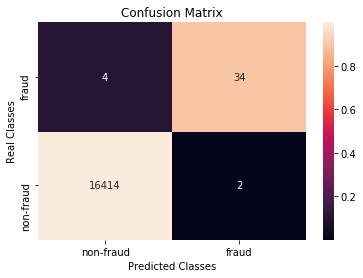

In [150]:
plot_confusion_matrix(y_test, y_preds)

In [151]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test, y_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     16416
       fraud       0.94      0.89      0.92        38

    accuracy                           1.00     16454
   macro avg       0.97      0.95      0.96     16454
weighted avg       1.00      1.00      1.00     16454



### SMOTE

Now that we have a baseline model using XGBoost, we can try to see if sampling techniques that are designed specifically for imbalanced problems can improve the performance of the model.

For that purpose we will be using the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) package that works well with scikit-learn. We have pre-installed the package for this kernel, but if you need it for a different Jupyter kernel you can install it by running `pip install --upgrade imbalanced-learn` within the conda environment you need.

We will be using [Sythetic Minority Over-sampling](https://arxiv.org/abs/1106.1813) (SMOTE), which oversamples the minority class by interpolating new data points between existing ones.

In [160]:
!pip install imbalanced-learn==0.6.0
!pip install scikit-learn==0.22.1


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 162 kB 23.4 MB/s eta 0:00:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.0
    Uninstalling imbalanced-learn-0.8.0:
      Successfully uninstalled imbalanced-learn-0.8.0
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/

In [161]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

We can see that SMOTE has now balanced the two classes:

In [163]:
from collections import Counter
print(sorted(Counter(y_smote).items()))

[(0.0, 147759), (1.0, 147759)]


We note that this is a case of extreme oversampling of the the minority class, we went from ~0.17% to 50%. An alternative would be to use a smaller resampling ratio, such as having one minority cl
ass sample for every `sqrt(non_fraud/fraud)` majority samples, or using more advanced resampling techniques. See the [comparison](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py) provided by imbalanced-learn for more over-sampling options.

In our case we'll use the SMOTE dataset we just created and upload it to S3 for training.

In [164]:
smote_buf = io.BytesIO()

# Dump the SMOTE data into a buffer
sklearn.datasets.dump_svmlight_file(X_smote, y_smote, smote_buf)
smote_buf.seek(0);

# Upload from the buffer to S3
key = 'fraud-dataset-smote'
subdir = 'smote'
boto3.resource('s3', region_name=region).Bucket(default_s3_bucket_name).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(smote_buf)

s3_smote_train_data = 's3://{}/{}/train/{}/{}'.format(bucket, prefix, subdir, key)
print('Uploaded training data location: {}'.format(s3_smote_train_data))

smote_output_location = 's3://{}/{}/smote-output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(smote_output_location))

Uploaded training data location: s3://sagemaker-us-east-1-365792799466/sagemaker-featurestore-demo/train/smote/fraud-dataset-smote
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-365792799466/sagemaker-featurestore-demo/smote-output


In [167]:
smote_xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker_iam_role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)
smote_xgb.set_hyperparameters(max_depth=5,
                        eval_metric='auc',
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [168]:
smote_xgb.fit({'train': s3_smote_train_data})

2021-08-23 18:39:38 Starting - Starting the training job...
2021-08-23 18:40:03 Starting - Launching requested ML instancesProfilerReport-1629743978: InProgress
.........
2021-08-23 18:41:23 Starting - Preparing the instances for training......
2021-08-23 18:42:38 Downloading - Downloading input data...
2021-08-23 18:43:05 Training - Downloading the training image...
2021-08-23 18:43:26 Training - Training image download completed. Training in progress.Arguments: train
[2021-08-23:18:43:27:INFO] Running standalone xgboost training.
[2021-08-23:18:43:27:INFO] Path /opt/ml/input/data/validation does not exist!
[2021-08-23:18:43:27:INFO] File size need to be processed in the node: 181.05mb. Available memory size in the node: 8404.46mb
[18:43:27] S3DistributionType set as FullyReplicated
[18:43:28] 295518x30 matrix with 8863812 entries loaded from /opt/ml/input/data/train
[18:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[0]#011

In [169]:
from sagemaker.predictor import CSVDeserializer,CSVSerializer

predictor = smote_xgb.deploy(initial_instance_count=1,
                       model_name="{}-xgb".format("fraud-detection-smote"),
                       endpoint_name="{}-xgb".format("fraud-detection-smote"),
                       instance_type="ml.c5.xlarge",
                       serializer=CSVSerializer(),
                       deserializer=None)

-------------!

In [170]:
smote_raw_preds = predict(smote_predictor, X_test)
smote_preds = np.where(smote_raw_preds > 0.5, 1, 0)

NameError: name 'smote_predictor' is not defined

In [ ]:
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, smote_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, smote_preds)))

In [ ]:
plot_confusion_matrix(y_test, smote_preds)

In [ ]:
print(classification_report(
    y_test, smote_preds, target_names=['non-fraud', 'fraud']))

Due to the randomness of XGBoost your results may vary, but overall, you should see a large increase in non-fraud cases being classified as fraud (false positives). The reason this happens is because SMOTE has oversampled the fraud class so much that it's increased its overlap in feature space with the non-fraud cases.
Since Cohen's Kappa gives more weight to false positives than balanced accuracy does, the metric drops significantly, as does the precision and F1 score for fraud cases. However, we can bring a balance between the metrics again by adjusting our classification threshold.

So far we've been using 0.5 as the threshold between labeling a point as fraud or not. We can try different thresholds to see if they affect the result of the classification. To evaluate we'll use the balanced accuracy and Cohen's Kappa metrics.

In [ ]:
for thres in np.linspace(0.1, 0.9, num=9):
    smote_thres_preds = np.where(smote_raw_preds > thres, 1, 0)
    print("Threshold: {:.1f}".format(thres))
    print("Balanced accuracy = {:.3f}".format(balanced_accuracy_score(y_test, smote_thres_preds)))
    print("Cohen's Kappa = {:.3f}\n".format(cohen_kappa_score(y_test, smote_thres_preds)))

We see that Cohen's Kappa keeps increasing along with the threshold, without a significant loss in balanced accuracy. This adds a useful knob to our model: We can keep a low threshold if we care more about not missing any fraudulent cases, or we can increase the threshold to try to minimize the number of false positives.